In [1]:
from sklearn.model_selection import train_test_split
import pandas
import numpy
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from pprint import pprint
from sklearn.cluster import KMeans, DBSCAN
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.utils import resample

**Reading Data**

In [2]:
data = pandas.read_csv('cs-training.csv')

In [3]:
# data.head()

**Removing NaNs and cleaning data**

In [4]:
data.dropna(axis=0,how='any',subset=['NumberOfDependents'],inplace=True)
data.dropna(axis=0,how='any',subset=['MonthlyIncome'],inplace=True)
data.reset_index()

train_frame = data[data.columns[1:]]
train_frame.columns[1:]

Index(['RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents'],
      dtype='object')

In [5]:
train_frame.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**Creating new features and cleaning more**

In [6]:
train_frame['MonthlyDebt'] = train_frame['DebtRatio']*train_frame['MonthlyIncome']
train_frame['NumOfPastDue'] = train_frame['NumberOfTimes90DaysLate']+train_frame['NumberOfTime60-89DaysPastDueNotWorse'] +train_frame['NumberOfTime30-59DaysPastDueNotWorse']
train_frame['MonthlyBalance'] = train_frame['MonthlyIncome']-train_frame['MonthlyDebt']

# We need only the observations where MonthlyBalance is positive
train_frame = train_frame[train_frame['MonthlyBalance'] > 0]

**Plot the distribution of each variable to see how skewed they are**

In [7]:
# columns = numpy.asarray(['RevolvingUtilizationOfUnsecuredLines','MonthlyDebt', 'MonthlyIncome', 'DebtRatio', 'age', 'MonthlyBalance',
#             'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue'])
# for cols in numpy.split(columns, 2):
#     fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
#     for each in range(len(cols)):
#         sns.distplot(train_frame[cols[each]], ax=axes[each])
#     plt.tight_layout()

**Taking log transform to reduce skeweness in some variables**

In [8]:
for column in ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumOfPastDue', 'MonthlyDebt',
              'MonthlyIncome', 'DebtRatio', 'NumberRealEstateLoansOrLines', 'MonthlyBalance']:
    train_frame[column] = numpy.log10(1 + train_frame[column].values)

**Plot distribution again**

In [9]:
# columns = numpy.asarray(['RevolvingUtilizationOfUnsecuredLines','MonthlyDebt', 'MonthlyIncome', 'DebtRatio', 'age', 'MonthlyBalance',
#             'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue'])
# for cols in numpy.split(columns, 2):
#     fig, axes = plt.subplots(1, len(cols), figsize = (20, 3))
#     for each in range(len(cols)):
#         sns.distplot(train_frame[cols[each]], ax=axes[each])
#     plt.tight_layout()

In [10]:
def oversample(x_train, y_train):
    X = pandas.concat([x_train, y_train], axis=1)
    no_risk = X[X.SeriousDlqin2yrs==0]
    risk = X[X.SeriousDlqin2yrs==1]
    risk_oversampled = resample(risk,replace=True, # sample with replacement
                              n_samples=len(no_risk/3), # match number in majority class
                              random_state=27) # reproducible results
    upsampled = pandas.concat([no_risk, risk_oversampled])
    return upsampled.iloc[:, :-1], upsampled.SeriousDlqin2yrs

**Removing outliers**

In [11]:
train_frame = train_frame[train_frame['age'] > 0]
train_frame = train_frame[train_frame['age'] < 99]

**Choosing features and splitting dataset**

In [12]:
features = ['RevolvingUtilizationOfUnsecuredLines', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate', 'NumOfPastDue']
x = train_frame[features]
y = train_frame['SeriousDlqin2yrs']
# x, y = oversample(x, y)

**Taking a scalar transform**

In [13]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

In [14]:
def evaluate(X, y_test, y_pred):
    ret_str = ''
    ret_str += 'Adjusted Rand Index: {}'.format( metrics.adjusted_rand_score(y_test, y_pred) ) + '\n'
    ret_str += 'Silhouette Coefficient: {}'.format( metrics.silhouette_score(X, y_pred, metric = "euclidean") )
    return ret_str   

In [15]:
def k_means(X, y_test):
    clustering = KMeans(n_clusters = 2, init = "k-means++", n_init = 4, max_iter=800, random_state = 0, algorithm = "auto").fit(X)
    clusters = clustering.labels_
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    ax = sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))

Adjusted Rand Index: 0.19019766249564832
Silhouette Coefficient: 0.6858996199186506


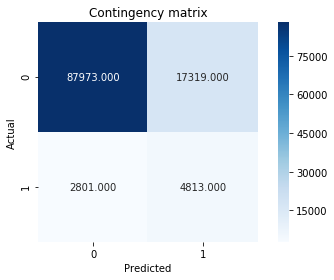

In [16]:
k_means(x, y)

In [17]:
def dbscan(X, y_test):
    clustering = DBSCAN(eps = 3, min_samples = 3, metric = "euclidean").fit(X)
    clusters = clustering.labels_
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    ax = sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5) #to fix glitch 
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))

In [18]:
# dbscan(x, y)

In [19]:
def hierarchical(X, y_test, method='single', metric='euclidean'):
    clustering = linkage(X, method = method, metric = metric)
    clusters = fcluster(clustering, 2, criterion = 'maxclust')
    cont_matrix = metrics.cluster.contingency_matrix(y_test, clusters)
    sns.heatmap(cont_matrix, annot = True, fmt = ".3f", square = True, cmap = plt.cm.Blues)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Contingency matrix')
    plt.tight_layout()
    print(evaluate(X, y_test, clusters))

In [20]:
# hierarchical(x, y)